In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
InputData = np.genfromtxt('Data/InputData.csv',delimiter=",")
t = np.genfromtxt('Data/time.csv',delimiter=",")
Data = np.genfromtxt('Data/OutputData.csv',delimiter=",")
print(f"OutData: %s, \nInputData: %s, \nTime: %s" %(np.shape(Data),np.shape(InputData),np.shape(t)))

OutData: (1000, 100), 
InputData: (100, 4), 
Time: (1000,)


In [3]:
n = Data.shape[1]
train_df = Data[:, 0:int(n*0.7):]
val_df = Data[:,int(n*0.7):int(n*0.9):]
test_df = Data[:,int(n*0.9):]

num_features = Data.shape[1]


In [4]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

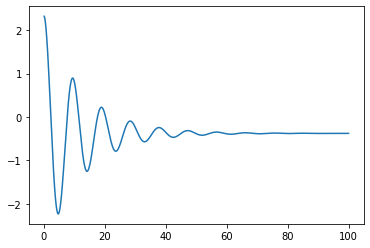

In [5]:
example_ind = 61
plt.plot(t,train_df[:,example_ind])


In [48]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df


    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}'])


In [49]:
def split_window(self, data):
    inputs = tf.stack(
      [data[:,self.input_slice,i] for i in range(0,data.shape[2]) ] , axis=0
    )
    labels = tf.stack(
      [data[:,self.labels_slice,i] for i in range(0,data.shape[2]) ] , axis=0
    )

    shape = [tf.shape(inputs)[k] for k in range(3)]
    inputs = tf.reshape(inputs, [shape[0]*shape[1], shape[2], 1])
    shape = [tf.shape(labels)[k] for k in range(3)]
    labels = tf.reshape(labels, [shape[0]*shape[1], shape[2], 1])

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width,1])
    labels.set_shape([None, self.label_width,1])

    return inputs, labels

WindowGenerator.split_window = split_window


In [50]:
def make_dataset(self, data,batch_size):
    data = np.array(data, dtype=np.float32)

    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data= data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size)
    ds = ds.map(self.split_window)
    return ds

@property
def train(self,batch_size=10):
    return self.make_dataset(self.train_df,batch_size)

@property
def val(self,batch_size=10):
    return self.make_dataset(self.val_df,batch_size)

@property
def test(self,batch_size=10):
    return self.make_dataset(self.test_df,batch_size)


WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [51]:
@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result
WindowGenerator.example = example

In [52]:
def plotexample(self, model=None, plot_col='x', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n,:,:],
              label='Inputs', marker='.', zorder=-10)
    plt.scatter(self.label_indices, labels[n,:,:],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n,:],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Timesteps')

WindowGenerator.plotexample = plotexample

In [62]:
def plot(self,model=None, plot_col='x',index=61):
    inputs = train_df[:,index]
    print(tf.shape(inputs))
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 1, 1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[:self.input_width],
                label='Inputs', marker='.', zorder=-10)
    print(self.label_indices)
    plt.scatter(self.label_indices, inputs[self.input_width:self.input_width+self.label_width],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if model is not None:
        predictions = model(inputs[:self.input_width])
        plt.scatter(self.label_indices, predictions[:],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

    if n == 0:
        plt.legend()

    plt.xlabel('Timesteps')

WindowGenerator.plot = plot